In [ ]:
!pip install darts

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models import NBEATSModel
from google.colab import files
from darts import TimeSeries

In [4]:
# Загрузка натренированной модели по адресу https://drive.google.com/file/d/1--8QBfOWZCDoTxlr8aZjcQgVMsmNtILx/view?usp=sharing

uploaded = files.upload()
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12)
model.load('savedmodel.pt')
model.load_weights('savedmodel.pt')

In [5]:
# Загрузка эксель файла с тестовым набором
#uploaded = files.upload()
data = pd.read_excel('test.xlsx')

# загрузка файла с ценами
#uploaded = files.upload()
price = pd.read_excel('Цены на сырье.xlsx')



---



In [6]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

mergedData = pd.merge(data, price, on="dt")
mergedData = mergedData.dropna(axis=1, how='all')
mergedData = mergedData.fillna(0)

for col in mergedData.columns:
    if col != 'dt' and col != 'Цена на арматуру':
      mergedData[col] = absolute_maximum_scale(mergedData[col])

In [7]:
DeleteColumns = ['Лом_3А, РФ FCA ж/д Кемеровская обл, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д Нижегородская обл, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д Новосибирская обл, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д Самарская обл, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д ХМАО, руб./т, без НДС',
                 'Лом_3А, РФ FCA ж/д Челябинская обл, руб./т, без НДС',
                 'Лом_Б26 легированный (Ni 9,3%), РФ CPT, руб./т, без НДС',
                 'Чугун_CFR Западная Европа, $/т',
                 'Чугун_FOB Бразилия Юг, $/т']

In [8]:
mergedData = mergedData.drop(DeleteColumns, axis=1)



---



In [9]:
time = TimeSeries.from_dataframe(mergedData, 'dt')

In [10]:
pred = model.predict(n=28, series=time)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [25]:
def graphicInterval(T, N):
  interval = T + N
  weeks_size = N

  predictionDataframe = pred.pd_dataframe()[['Цена на арматуру']]
  predictionDataframe["moving_average"] = predictionDataframe["Цена на арматуру"].rolling(weeks_size).mean()
  predictionDataframe["upper"] = predictionDataframe["moving_average"] + 0.5 * predictionDataframe["Цена на арматуру"].rolling(weeks_size).std()
  predictionDataframe["lower"] = predictionDataframe["moving_average"] - 0.5 * predictionDataframe["Цена на арматуру"].rolling(weeks_size).std()

  predictionDataframe = predictionDataframe.tail(interval)

  plt.plot(predictionDataframe.index, predictionDataframe["Цена на арматуру"], label="Цена на арматуру")
  plt.plot(predictionDataframe.index, predictionDataframe["moving_average"], label="Среднее скользящее цены")

  plt.fill_between(predictionDataframe.index, predictionDataframe["lower"], predictionDataframe["upper"], alpha=0.2, label="Диапазон допустимых цен")
  point_value = predictionDataframe.iloc[T]["Цена на арматуру"]
  plt.scatter(predictionDataframe.index[T], point_value, color="red", s=100, label="Текущая неделя")

  plt.title("Цена на арматуру за {} недель".format(weeks_size))
  plt.rcParams['figure.figsize'] = [10,10]
  plt.legend()
  plt.show()
  return predictionDataframe

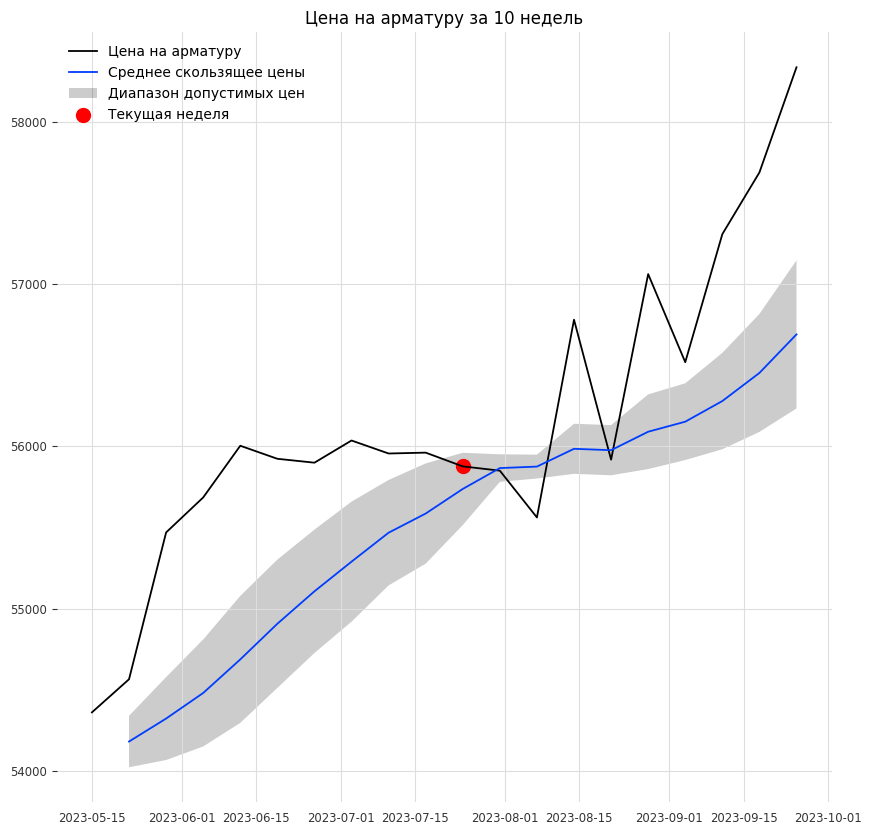

In [26]:
itog = graphicInterval(10, 10)
itog = itog.reset_index()


In [22]:
itog['Закупка на недели'] = 0

currentIndex = 0
Nedeli = 0
for index, row in itog.iterrows():
    if row['Цена на арматуру'] < row['upper'] or Nedeli == 10 or index==itog.index[-1]:
      if index < itog.index[-1] and (itog['Цена на арматуру'][index] < itog['Цена на арматуру'][index+1]) and Nedeli <10:
        Nedeli=Nedeli+1
        continue
      else:
        itog['Закупка на недели'][currentIndex] = Nedeli  #index - currentIndex
        if index==itog.index[-1]:
          itog['Закупка на недели'][currentIndex] +=1
          continue
        currentIndex = index
        Nedeli = 1
    else:
      Nedeli = Nedeli +1

itog

11


<ipython-input-22-43adcd5b238a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itog['Закупка на недели'][currentIndex] = Nedeli  #index - currentIndex
<ipython-input-22-43adcd5b238a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itog['Закупка на недели'][currentIndex] +=1


component,dt,Цена на арматуру,moving_average,upper,lower,Закупка на недели
0,2023-05-15,54361.856158,NaN,NaN,NaN,10
1,2023-05-22,54565.804923,54182.163883,54340.770547,54023.557220,0
2,2023-05-29,55470.006577,54323.671525,54579.042981,54068.300069,0
3,2023-06-05,55685.634262,54481.217572,54810.732306,54151.702838,0
4,2023-06-12,56004.094922,54688.008242,55078.995354,54297.021130,0
5,2023-06-19,55923.700759,54907.618444,55302.924807,54512.312080,0
6,2023-06-26,55899.688695,55107.388484,55487.426751,54727.350217,0
7,2023-07-03,56036.334296,55290.029422,55659.840537,54920.218308,0
8,2023-07-10,55956.260265,55468.411043,55793.305720,55143.516366,0
9,2023-07-17,55961.570121,55586.495098,55895.206464,55277.783732,0
